# Generative Adversarial Networks (GAN)

Let us look at some examples to understand what a GAN and its variants are capable of.

- Given a segmented image of the road, the network is able to fill in the details with objects such as cars etc. The network is able to convert a black & white image into colour. Given an aerial map, the network is able to find the roads in the image. It is also able to fill in the details of a photo, given the edges.

- Given an image of a face, the network can construct an image which represents how that person could look when they are old.

## Introduction

The network learns to generate from a training distribution through a 2-player game. The two entities are Generator and Discriminator. These two adversaries are in constant battle throughout the training process. Since an adversarial learning method is adopted, we need not care about approximating intractable density functions.

## How it works



# https://cdn-images-1.medium.com/max/1600/1*XKanAdkjQbg1eDDMF2-4ow.png

As you can identify from their names, a generator is used to generate real-looking images and the discriminator’s job is to identify which one is a fake. The entities/adversaries are in constant battle as one(generator) tries to fool the other(discriminator), while the other tries not to be fooled. To generate the best images you will need a very good generator and a discriminator. This is because if your generator is not good enough, it will never be able to fool the discriminator and the model will never converge. If the discriminator is bad, then images which make no sense will also be classified as real and hence your model never trains and in turn you never produces the desired output. The input, random noise can be a Gaussian distribution and values can be sampled from this distribution and fed into the generator network and an image is generated. This generated image is compared with a real image by the discriminator and it tries to identify if the given image is fake or real.

In [1]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
import torch.nn.functional as F
from PIL import Image


import matplotlib.pyplot as plt

### Reading the csv file into it

In [2]:
df_train = pd.read_csv("data/fashion-mnist_train.csv")
df_test = pd.read_csv("data/fashion-mnist_test.csv")

In [3]:
class FashionMNIST(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv('data/fashion-mnist_train.csv')
        self.labels = fashion_df.label.values
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

In [4]:
dataset = FashionMNIST()

In [5]:
dataset[0][0]

In [6]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
dataset = FashionMNIST(transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Now let's define the discriminator and generator. For both the generator and discriminator, we will create a neural network with three hidden layers with the activation function being the Leaky Relu. We also add dropout layers for the discriminator to improve its robustness on unseen images.

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [9]:
generator = Generator()
discriminator = Discriminator()

In [10]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [11]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    
    z = torch.randn(batch_size, 100)
    fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size))
    fake_images = generator(z, fake_labels)
    
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, torch.ones(batch_size))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data[0]

In [12]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, torch.ones(batch_size))
    
    # train with fake images
    z = torch.randn(batch_size, 100)
    fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size))
    fake_images = generator(z, fake_labels)
    
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, torch.zeros(batch_size))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data[0]

Starting epoch 0...


/Users/dimitriwilhelm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/dimitriwilhelm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':


g_loss: 3.1164584159851074, d_loss: 0.4186621308326721


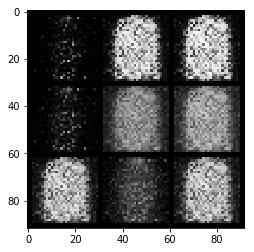

Starting epoch 1...
g_loss: 3.53499436378479, d_loss: 0.19911018013954163


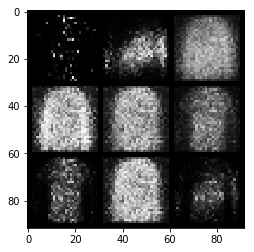

Starting epoch 2...
g_loss: 3.779385566711426, d_loss: 0.2877115309238434


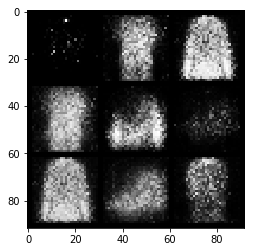

Starting epoch 3...
g_loss: 3.024681568145752, d_loss: 0.6452053189277649


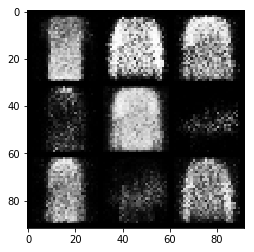

Starting epoch 4...
g_loss: 2.2927515506744385, d_loss: 0.5447673797607422


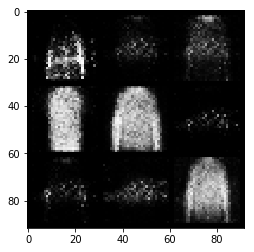

Starting epoch 5...
g_loss: 2.7403063774108887, d_loss: 0.6736639738082886


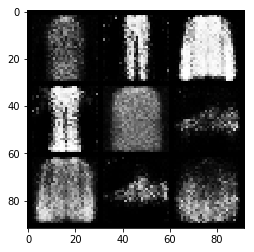

Starting epoch 6...
g_loss: 1.8758587837219238, d_loss: 0.6003169417381287


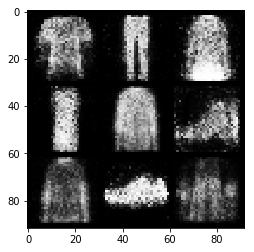

Starting epoch 7...
g_loss: 2.3996975421905518, d_loss: 0.6455930471420288


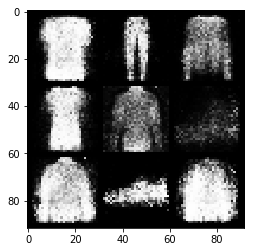

Starting epoch 8...
g_loss: 2.218395709991455, d_loss: 0.8159686923027039


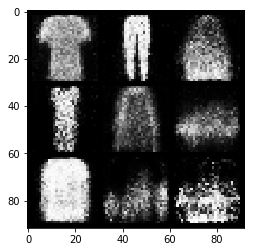

Starting epoch 9...
g_loss: 1.830930471420288, d_loss: 0.6982471942901611


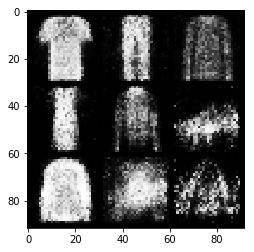

Starting epoch 10...
g_loss: 1.8095629215240479, d_loss: 0.9102783799171448


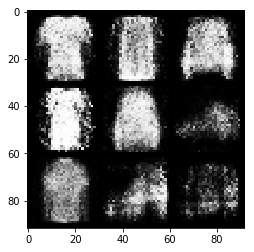

Starting epoch 11...
g_loss: 1.6294960975646973, d_loss: 0.7658526301383972


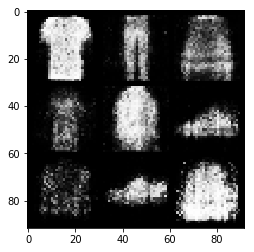

Starting epoch 12...
g_loss: 2.1855580806732178, d_loss: 0.6777029633522034


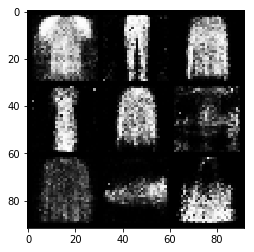

Starting epoch 13...
g_loss: 1.5336517095565796, d_loss: 0.7961398959159851


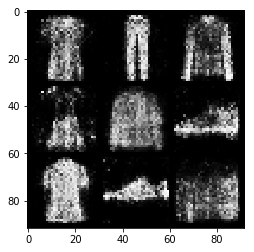

Starting epoch 14...
g_loss: 1.558103084564209, d_loss: 0.8043106198310852


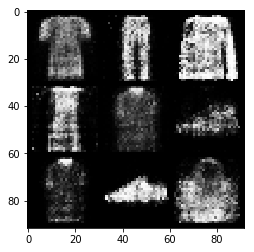

Starting epoch 15...
g_loss: 1.3188917636871338, d_loss: 0.9066983461380005


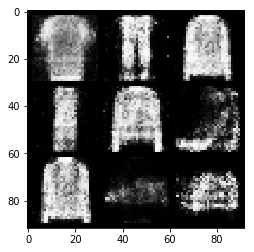

Starting epoch 16...
g_loss: 1.270957350730896, d_loss: 0.9223295450210571


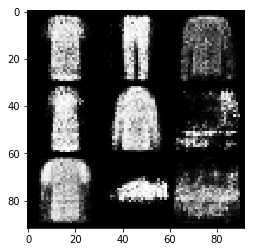

Starting epoch 17...
g_loss: 1.7209763526916504, d_loss: 1.0657538175582886


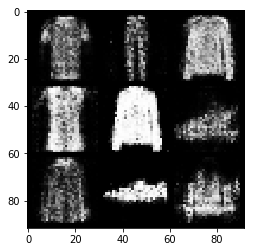

Starting epoch 18...
g_loss: 1.4649332761764526, d_loss: 1.0953155755996704


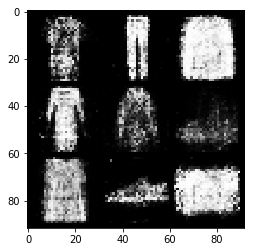

Starting epoch 19...
g_loss: 1.4883711338043213, d_loss: 1.2312743663787842


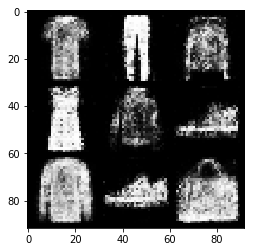

Starting epoch 20...
g_loss: 1.1787500381469727, d_loss: 0.7983155846595764


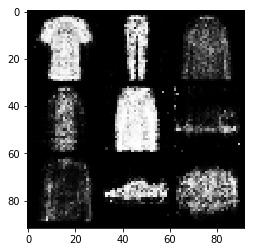

Starting epoch 21...
g_loss: 1.4854910373687744, d_loss: 0.9615873098373413


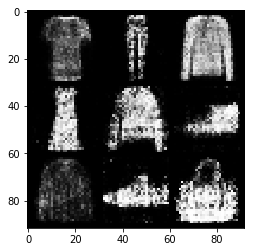

Starting epoch 22...
g_loss: 1.2476081848144531, d_loss: 0.8358471989631653


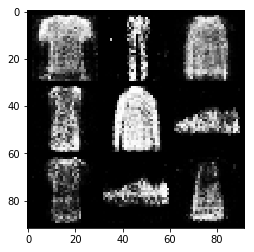

Starting epoch 23...
g_loss: 1.2785571813583374, d_loss: 0.9225445985794067


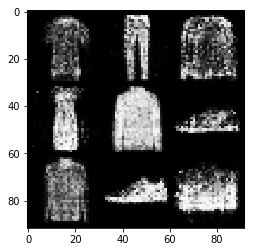

Starting epoch 24...
g_loss: 1.4352636337280273, d_loss: 1.0623323917388916


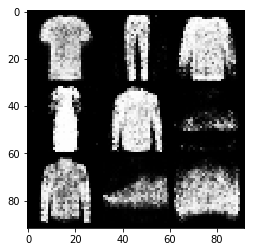

Starting epoch 25...
g_loss: 1.1053431034088135, d_loss: 1.130371332168579


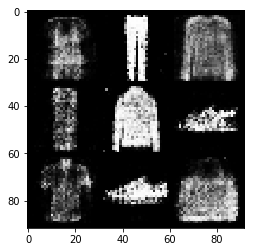

Starting epoch 26...
g_loss: 1.0803686380386353, d_loss: 1.3009891510009766


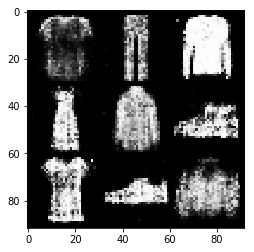

Starting epoch 27...
g_loss: 1.2198455333709717, d_loss: 1.1243865489959717


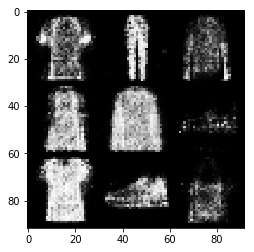

Starting epoch 28...
g_loss: 1.359838604927063, d_loss: 0.924543023109436


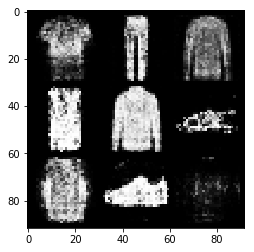

Starting epoch 29...
g_loss: 1.2004700899124146, d_loss: 1.2126237154006958


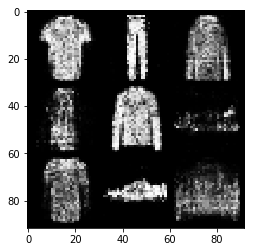

In [13]:
num_epochs = 30
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for batch_id, (images, labels) in enumerate(data_loader):
        real_images = images
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = torch.randn(9, 100)
    labels = torch.LongTensor(np.arange(9))
    sample_images = generator(z, labels).unsqueeze(1).data
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

### Disadvantages
GANs are more unstable to train because you have to train two networks from a single backpropagation. Therefore choosing the right objectives can make a big difference.
We cannot perform any inference queries with GANs